### Import Packages


In [1]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.7.0


### MNIST dataset is provided in default

In [2]:
train_path = './mnist_train_small.csv'
test_path = './mnist_test.csv'
img_size = 28

### Choose your device - use GPU or not?

In [3]:
# device = 'cpu'
device = 'cuda'
print('Current Device : {}'.format(device))

Current Device : cuda


### Read the MNIST dataset
- total 1+ 28x28 dimension. 1 For Label, 28**2 for image


In [4]:
def mnist_reader(file_path, img_size=img_size):
    total_img = list()
    total_label = list()
    with open(file_path) as csvfile:
        mnist_reader = csv.reader(csvfile)
        for row in tqdm(mnist_reader):
            img = np.array(row[1:], dtype=np.uint16).reshape(img_size, img_size)
            img = (img / 255) * 2 - 1 # normalize the image between -1~1
            label = int(row[0])

            total_img.append(img)
            total_label.append(label)

    total_img = np.asarray(total_img)
    total_label = np.asarray(total_label)
    
    return total_img, total_label

In [5]:
train_img, train_label = mnist_reader(train_path)
test_img, test_label = mnist_reader(test_path)

### Define the Dataset

In [6]:
class MNIST_Dataset(Dataset):
    def __init__(self, target_img, target_label):
        self.target_img = target_img
        self.target_label = target_label
        self.num_data = target_img.shape[0]

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        sample = dict()
        sample['img'] = self.target_img[idx]
        sample['label'] = self.target_label[idx]

        return sample

### Define the DataLoader

In [7]:
batch_size = 64

train_dataset = MNIST_Dataset(train_img, train_label)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### Try to sample out one data point from dataloader

In [8]:
sample = next(iter(train_dataloader))
print(sample['img'].shape)
print(sample['label'].shape)

torch.Size([64, 28, 28])
torch.Size([64])


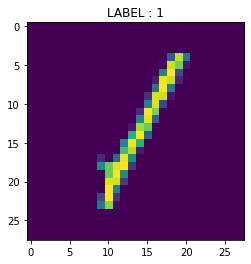

In [9]:
plot_idx = 0
plt.imshow(sample['img'][plot_idx])
plt.title('LABEL : {}'.format(sample['label'][plot_idx]))
plt.show()

### Define the GAN (Generator + Discriminator)


In [22]:
class Generator(nn.Module):
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_z, dim_input=img_size**2):
        super(Generator, self).__init__()
        
        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_z = dim_z
        self.dim_input = dim_input

        # define generator fc -> bn -> act -> fc ....
        self.fc_1 = nn.Linear(self.dim_z, self.dim_hidden_1)
        self.fc_2 = nn.Linear(self.dim_hidden_1, self.dim_hidden_2)
        self.fc_3 = nn.Linear(self.dim_hidden_2, self.dim_input)
        self.bn_1 = nn.BatchNorm1d(self.dim_hidden_1)
        self.bn_2 = nn.BatchNorm1d(self.dim_hidden_2)
        
        self.activation = nn.LeakyReLU(0.2)
    
    def forward(self, z):
        '''
        input : z - sampled random vector
        output : image between -1~1
        '''
        out = self.activation(self.bn_1(self.fc_1(z)))
        out = self.activation(self.bn_2(self.fc_2(out)))
        out = self.fc_3(out)
        
        return torch.tanh(out)

class Discriminator(nn.Module): 
    def __init__(self, dim_hidden_1, dim_hidden_2, dim_input=img_size**2):
        super(Discriminator, self).__init__()

        # define hidden dimension
        self.dim_hidden_1 = dim_hidden_1
        self.dim_hidden_2 = dim_hidden_2
        self.dim_input = dim_input

        # define discriminator
        self.fc_1 = nn.Linear(self.dim_input, self.dim_hidden_1)
        self.fc_2 = nn.Linear(self.dim_hidden_1, self.dim_hidden_2)
        self.fc_3 = nn.Linear(self.dim_hidden_2, 1)
        
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        '''
        input : image x - N by W*H dimension
        output : value between 0~1
        '''
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        out = self.activation(self.fc_1(x))
        out = self.activation(self.fc_2(out))
        out = self.fc_3(out)
        
        return torch.sigmoid(out).squeeze(1)


### Define the Model

In [23]:
dim_hidden_1 = 256
dim_hidden_2 = 512
dim_z = 128
generator = Generator(dim_hidden_1, dim_hidden_2, dim_z).to(device)
discriminator = Discriminator(dim_hidden_1, dim_hidden_2).to(device)

gen_optimizer = optim.Adam(generator.parameters(), lr=2e-5, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=2e-5, betas=(0.5, 0.999))

print(generator)
print(discriminator)

Generator(
  (fc_1): Linear(in_features=128, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=784, bias=True)
  (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.2)
)
Discriminator(
  (fc_1): Linear(in_features=784, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=512, bias=True)
  (fc_3): Linear(in_features=512, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.2)
)


### Define functions for train/test

In [17]:
def train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample):
    generator.train()
    
    batch_size = sample['img'].shape[0]

    criterion = nn.BCELoss() #need to calculate sigmoid 
    real_label = torch.ones(batch_size).to(device)
    fake_label = torch.zeros(batch_size).to(device)
    
    sample_z = torch.randn(batch_size, dim_z).to(device)
    real_img = sample['img'].float().to(device)
    fake_img = generator(sample_z)
    
    # Train Generator
    
    gen_optimizer.zero_grad()

    g_loss = criterion(discriminator(fake_img), real_label)
    
    g_loss.backward()
    gen_optimizer.step()
    
    # Train Discriminator
    discriminator.train()
    dis_optimizer.zero_grad()

    real_loss = criterion(discriminator(real_img), real_label)
    fake_loss = criterion(discriminator(fake_img.detach()), fake_label)
    d_loss = (real_loss + fake_loss) / 2

    d_loss.backward()
    dis_optimizer.step()    

    return g_loss.item(), d_loss.item()    
    

In [15]:
def test(generator, img_size, dim_z):
    generator.eval()
    with torch.no_grad():
        sample_z = torch.randn(1, dim_z).to(device)
        fake_data = generator(sample_z.to(device))

    return 0.5*(fake_data.view(img_size, img_size).detach().cpu().numpy() + 1)

### Run Training

[EPOCH 0] SAMPLED G LOSS : 0.6774632334709167, SAMPLED D LOSS : 0.6755062341690063
[EPOCH 0] SAMPLED G LOSS : 0.529943585395813, SAMPLED D LOSS : 0.5712183713912964


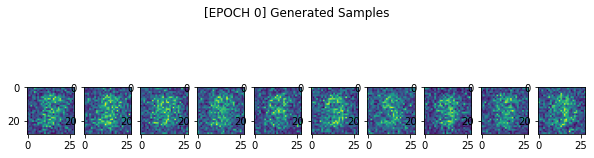

[EPOCH 1] SAMPLED G LOSS : 0.5241265296936035, SAMPLED D LOSS : 0.6231255531311035
[EPOCH 1] SAMPLED G LOSS : 0.5773104429244995, SAMPLED D LOSS : 0.6429693102836609
[EPOCH 2] SAMPLED G LOSS : 0.6079061031341553, SAMPLED D LOSS : 0.6389642953872681
[EPOCH 2] SAMPLED G LOSS : 0.6498962640762329, SAMPLED D LOSS : 0.601791262626648
[EPOCH 3] SAMPLED G LOSS : 0.6873897314071655, SAMPLED D LOSS : 0.5660640001296997
[EPOCH 3] SAMPLED G LOSS : 0.6687264442443848, SAMPLED D LOSS : 0.5973482728004456
[EPOCH 4] SAMPLED G LOSS : 0.660834550857544, SAMPLED D LOSS : 0.5788832902908325
[EPOCH 4] SAMPLED G LOSS : 0.7089172601699829, SAMPLED D LOSS : 0.5431997776031494
[EPOCH 5] SAMPLED G LOSS : 0.7607743144035339, SAMPLED D LOSS : 0.5193110704421997
[EPOCH 5] SAMPLED G LOSS : 0.813902735710144, SAMPLED D LOSS : 0.5057453513145447
[EPOCH 6] SAMPLED G LOSS : 0.8742002248764038, SAMPLED D LOSS : 0.5011786222457886
[EPOCH 6] SAMPLED G LOSS : 0.8237922787666321, SAMPLED D LOSS : 0.5195895433425903
[EPOCH 

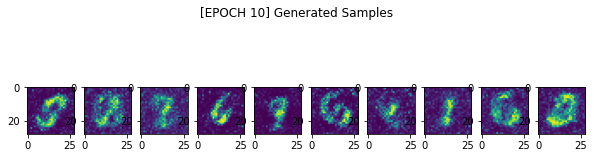

[EPOCH 11] SAMPLED G LOSS : 1.1100432872772217, SAMPLED D LOSS : 0.43059951066970825
[EPOCH 11] SAMPLED G LOSS : 1.073629379272461, SAMPLED D LOSS : 0.4476144015789032
[EPOCH 12] SAMPLED G LOSS : 0.9347999095916748, SAMPLED D LOSS : 0.46310409903526306
[EPOCH 12] SAMPLED G LOSS : 0.9799071550369263, SAMPLED D LOSS : 0.46838223934173584
[EPOCH 13] SAMPLED G LOSS : 0.9948997497558594, SAMPLED D LOSS : 0.47262096405029297
[EPOCH 13] SAMPLED G LOSS : 0.9388887286186218, SAMPLED D LOSS : 0.4592951536178589
[EPOCH 14] SAMPLED G LOSS : 1.0194430351257324, SAMPLED D LOSS : 0.454807311296463
[EPOCH 14] SAMPLED G LOSS : 0.9047161936759949, SAMPLED D LOSS : 0.470062255859375
[EPOCH 15] SAMPLED G LOSS : 0.9354622960090637, SAMPLED D LOSS : 0.4508070647716522
[EPOCH 15] SAMPLED G LOSS : 0.7727534174919128, SAMPLED D LOSS : 0.5138438940048218
[EPOCH 16] SAMPLED G LOSS : 0.8539451360702515, SAMPLED D LOSS : 0.48026043176651
[EPOCH 16] SAMPLED G LOSS : 1.4167205095291138, SAMPLED D LOSS : 0.5053546428

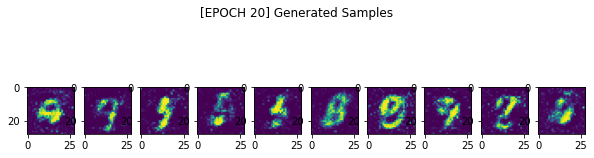

[EPOCH 21] SAMPLED G LOSS : 0.8872568011283875, SAMPLED D LOSS : 0.44447213411331177
[EPOCH 21] SAMPLED G LOSS : 1.255530595779419, SAMPLED D LOSS : 0.46811965107917786
[EPOCH 22] SAMPLED G LOSS : 1.1711468696594238, SAMPLED D LOSS : 0.5005658864974976
[EPOCH 22] SAMPLED G LOSS : 1.0348711013793945, SAMPLED D LOSS : 0.5146005153656006
[EPOCH 23] SAMPLED G LOSS : 0.962870717048645, SAMPLED D LOSS : 0.4634310007095337
[EPOCH 23] SAMPLED G LOSS : 0.7849414348602295, SAMPLED D LOSS : 0.4992389678955078
[EPOCH 24] SAMPLED G LOSS : 1.0995538234710693, SAMPLED D LOSS : 0.47060009837150574
[EPOCH 24] SAMPLED G LOSS : 1.1485295295715332, SAMPLED D LOSS : 0.48417603969573975
[EPOCH 25] SAMPLED G LOSS : 1.0628108978271484, SAMPLED D LOSS : 0.5013477206230164
[EPOCH 25] SAMPLED G LOSS : 1.1080658435821533, SAMPLED D LOSS : 0.4708348512649536
[EPOCH 26] SAMPLED G LOSS : 0.7784131765365601, SAMPLED D LOSS : 0.5134475231170654
[EPOCH 26] SAMPLED G LOSS : 1.0278465747833252, SAMPLED D LOSS : 0.5042390

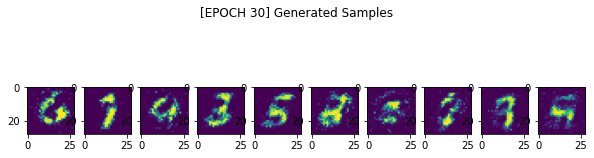

[EPOCH 31] SAMPLED G LOSS : 0.6950088739395142, SAMPLED D LOSS : 0.5302431583404541
[EPOCH 31] SAMPLED G LOSS : 0.8527289628982544, SAMPLED D LOSS : 0.4958469867706299
[EPOCH 32] SAMPLED G LOSS : 1.247711420059204, SAMPLED D LOSS : 0.5176151990890503
[EPOCH 32] SAMPLED G LOSS : 1.1284185647964478, SAMPLED D LOSS : 0.4691605865955353
[EPOCH 33] SAMPLED G LOSS : 0.9363201856613159, SAMPLED D LOSS : 0.4782019257545471
[EPOCH 33] SAMPLED G LOSS : 0.718984842300415, SAMPLED D LOSS : 0.5267850160598755
[EPOCH 34] SAMPLED G LOSS : 1.324793815612793, SAMPLED D LOSS : 0.5215353965759277
[EPOCH 34] SAMPLED G LOSS : 0.7391238808631897, SAMPLED D LOSS : 0.5279057025909424
[EPOCH 35] SAMPLED G LOSS : 1.106575846672058, SAMPLED D LOSS : 0.5035871267318726
[EPOCH 35] SAMPLED G LOSS : 0.7119524478912354, SAMPLED D LOSS : 0.5634065270423889
[EPOCH 36] SAMPLED G LOSS : 0.9896324276924133, SAMPLED D LOSS : 0.5306881666183472
[EPOCH 36] SAMPLED G LOSS : 0.7863867282867432, SAMPLED D LOSS : 0.5164788961410

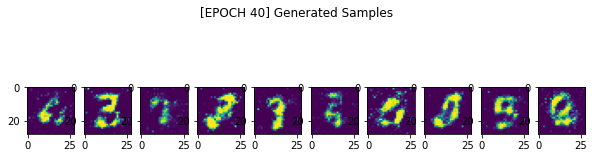

[EPOCH 41] SAMPLED G LOSS : 0.7768121957778931, SAMPLED D LOSS : 0.5194481611251831
[EPOCH 41] SAMPLED G LOSS : 0.8836463093757629, SAMPLED D LOSS : 0.5293170213699341
[EPOCH 42] SAMPLED G LOSS : 1.066582441329956, SAMPLED D LOSS : 0.48911288380622864
[EPOCH 42] SAMPLED G LOSS : 1.0727877616882324, SAMPLED D LOSS : 0.5402936935424805
[EPOCH 43] SAMPLED G LOSS : 0.9934500455856323, SAMPLED D LOSS : 0.5098903179168701
[EPOCH 43] SAMPLED G LOSS : 0.9977219104766846, SAMPLED D LOSS : 0.49860313534736633
[EPOCH 44] SAMPLED G LOSS : 1.2435953617095947, SAMPLED D LOSS : 0.5671169757843018
[EPOCH 44] SAMPLED G LOSS : 0.8672150373458862, SAMPLED D LOSS : 0.48888540267944336
[EPOCH 45] SAMPLED G LOSS : 1.0391770601272583, SAMPLED D LOSS : 0.46906590461730957
[EPOCH 45] SAMPLED G LOSS : 0.860721230506897, SAMPLED D LOSS : 0.5197997093200684
[EPOCH 46] SAMPLED G LOSS : 0.8426554203033447, SAMPLED D LOSS : 0.5189051032066345
[EPOCH 46] SAMPLED G LOSS : 0.8293718099594116, SAMPLED D LOSS : 0.5202124

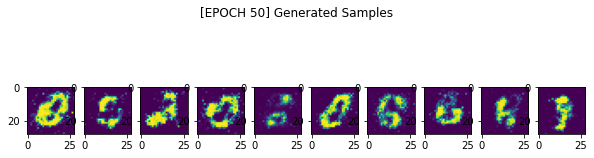

[EPOCH 51] SAMPLED G LOSS : 1.0705618858337402, SAMPLED D LOSS : 0.5080667734146118
[EPOCH 51] SAMPLED G LOSS : 0.9957332015037537, SAMPLED D LOSS : 0.5282845497131348
[EPOCH 52] SAMPLED G LOSS : 1.1184353828430176, SAMPLED D LOSS : 0.5402393937110901
[EPOCH 52] SAMPLED G LOSS : 1.0163542032241821, SAMPLED D LOSS : 0.522356390953064
[EPOCH 53] SAMPLED G LOSS : 1.6389340162277222, SAMPLED D LOSS : 0.5369847416877747
[EPOCH 53] SAMPLED G LOSS : 1.2337393760681152, SAMPLED D LOSS : 0.5316931009292603
[EPOCH 54] SAMPLED G LOSS : 0.5899497866630554, SAMPLED D LOSS : 0.5610733032226562
[EPOCH 54] SAMPLED G LOSS : 1.3048529624938965, SAMPLED D LOSS : 0.49628376960754395
[EPOCH 55] SAMPLED G LOSS : 0.8656371831893921, SAMPLED D LOSS : 0.5373848676681519
[EPOCH 55] SAMPLED G LOSS : 0.8460266590118408, SAMPLED D LOSS : 0.5098381638526917
[EPOCH 56] SAMPLED G LOSS : 0.9752135276794434, SAMPLED D LOSS : 0.4886217713356018
[EPOCH 56] SAMPLED G LOSS : 0.9387041926383972, SAMPLED D LOSS : 0.525155425

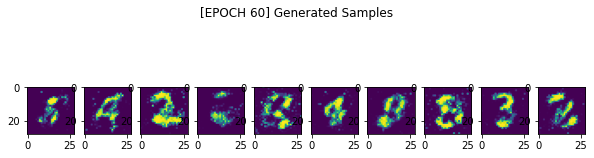

[EPOCH 61] SAMPLED G LOSS : 1.0638084411621094, SAMPLED D LOSS : 0.5130819082260132
[EPOCH 61] SAMPLED G LOSS : 1.1063016653060913, SAMPLED D LOSS : 0.5094221830368042
[EPOCH 62] SAMPLED G LOSS : 0.9835649728775024, SAMPLED D LOSS : 0.45989543199539185
[EPOCH 62] SAMPLED G LOSS : 1.017688274383545, SAMPLED D LOSS : 0.5258172750473022
[EPOCH 63] SAMPLED G LOSS : 1.3552595376968384, SAMPLED D LOSS : 0.5464776754379272
[EPOCH 63] SAMPLED G LOSS : 1.1608058214187622, SAMPLED D LOSS : 0.4807099401950836
[EPOCH 64] SAMPLED G LOSS : 0.7415148019790649, SAMPLED D LOSS : 0.5240634679794312
[EPOCH 64] SAMPLED G LOSS : 1.1715850830078125, SAMPLED D LOSS : 0.5091995000839233
[EPOCH 65] SAMPLED G LOSS : 1.1090774536132812, SAMPLED D LOSS : 0.46572548151016235
[EPOCH 65] SAMPLED G LOSS : 1.440781593322754, SAMPLED D LOSS : 0.49506157636642456
[EPOCH 66] SAMPLED G LOSS : 0.9434731006622314, SAMPLED D LOSS : 0.5252150893211365
[EPOCH 66] SAMPLED G LOSS : 0.9683026671409607, SAMPLED D LOSS : 0.49750876

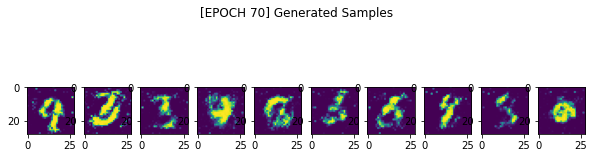

[EPOCH 71] SAMPLED G LOSS : 1.3139619827270508, SAMPLED D LOSS : 0.4819727838039398
[EPOCH 71] SAMPLED G LOSS : 1.0618228912353516, SAMPLED D LOSS : 0.5021214485168457
[EPOCH 72] SAMPLED G LOSS : 1.0649950504302979, SAMPLED D LOSS : 0.4668450653553009
[EPOCH 72] SAMPLED G LOSS : 1.0331518650054932, SAMPLED D LOSS : 0.5288065671920776
[EPOCH 73] SAMPLED G LOSS : 0.9397919178009033, SAMPLED D LOSS : 0.48682594299316406
[EPOCH 73] SAMPLED G LOSS : 1.5859668254852295, SAMPLED D LOSS : 0.5500702857971191
[EPOCH 74] SAMPLED G LOSS : 1.0273282527923584, SAMPLED D LOSS : 0.4954506456851959
[EPOCH 74] SAMPLED G LOSS : 1.0806893110275269, SAMPLED D LOSS : 0.4677882790565491
[EPOCH 75] SAMPLED G LOSS : 1.3225862979888916, SAMPLED D LOSS : 0.50612872838974
[EPOCH 75] SAMPLED G LOSS : 1.225691556930542, SAMPLED D LOSS : 0.48575833439826965
[EPOCH 76] SAMPLED G LOSS : 1.2245460748672485, SAMPLED D LOSS : 0.4592602252960205
[EPOCH 76] SAMPLED G LOSS : 1.6140371561050415, SAMPLED D LOSS : 0.5571514368

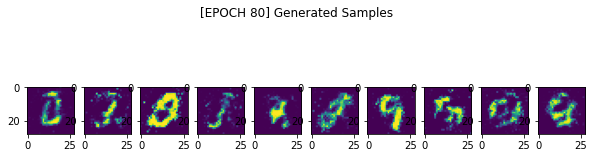

[EPOCH 81] SAMPLED G LOSS : 1.0186113119125366, SAMPLED D LOSS : 0.4656704068183899
[EPOCH 81] SAMPLED G LOSS : 1.3349766731262207, SAMPLED D LOSS : 0.47292137145996094
[EPOCH 82] SAMPLED G LOSS : 1.3571887016296387, SAMPLED D LOSS : 0.4257798492908478
[EPOCH 82] SAMPLED G LOSS : 1.0905201435089111, SAMPLED D LOSS : 0.49286168813705444
[EPOCH 83] SAMPLED G LOSS : 1.6329326629638672, SAMPLED D LOSS : 0.5099881291389465
[EPOCH 83] SAMPLED G LOSS : 1.2310391664505005, SAMPLED D LOSS : 0.5102839469909668
[EPOCH 84] SAMPLED G LOSS : 1.7897425889968872, SAMPLED D LOSS : 0.5420315861701965
[EPOCH 84] SAMPLED G LOSS : 1.1755200624465942, SAMPLED D LOSS : 0.5325243473052979
[EPOCH 85] SAMPLED G LOSS : 1.8076467514038086, SAMPLED D LOSS : 0.5266746878623962
[EPOCH 85] SAMPLED G LOSS : 0.954963743686676, SAMPLED D LOSS : 0.5035718679428101
[EPOCH 86] SAMPLED G LOSS : 0.8612926006317139, SAMPLED D LOSS : 0.511919379234314
[EPOCH 86] SAMPLED G LOSS : 1.4125773906707764, SAMPLED D LOSS : 0.508793473

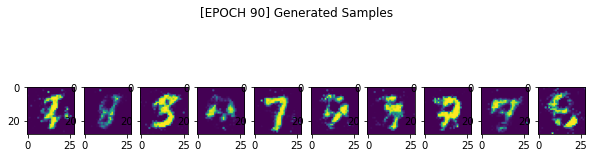

[EPOCH 91] SAMPLED G LOSS : 1.1828463077545166, SAMPLED D LOSS : 0.5035712718963623
[EPOCH 91] SAMPLED G LOSS : 1.2367855310440063, SAMPLED D LOSS : 0.47983139753341675
[EPOCH 92] SAMPLED G LOSS : 1.4217603206634521, SAMPLED D LOSS : 0.48462948203086853
[EPOCH 92] SAMPLED G LOSS : 1.4214317798614502, SAMPLED D LOSS : 0.4652915596961975
[EPOCH 93] SAMPLED G LOSS : 1.1985604763031006, SAMPLED D LOSS : 0.3924197554588318
[EPOCH 93] SAMPLED G LOSS : 1.5646235942840576, SAMPLED D LOSS : 0.5344244241714478
[EPOCH 94] SAMPLED G LOSS : 1.219773769378662, SAMPLED D LOSS : 0.50114506483078
[EPOCH 94] SAMPLED G LOSS : 1.1990087032318115, SAMPLED D LOSS : 0.509699285030365
[EPOCH 95] SAMPLED G LOSS : 1.0656943321228027, SAMPLED D LOSS : 0.4754473865032196
[EPOCH 95] SAMPLED G LOSS : 1.0717051029205322, SAMPLED D LOSS : 0.4697180390357971
[EPOCH 96] SAMPLED G LOSS : 0.8578674793243408, SAMPLED D LOSS : 0.48951074481010437
[EPOCH 96] SAMPLED G LOSS : 1.4573975801467896, SAMPLED D LOSS : 0.4812594056

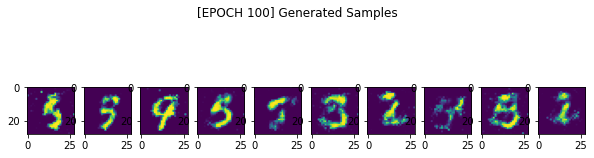

[EPOCH 101] SAMPLED G LOSS : 1.2212622165679932, SAMPLED D LOSS : 0.5285120010375977
[EPOCH 101] SAMPLED G LOSS : 1.1830228567123413, SAMPLED D LOSS : 0.491374135017395
[EPOCH 102] SAMPLED G LOSS : 0.9657458066940308, SAMPLED D LOSS : 0.48904532194137573
[EPOCH 102] SAMPLED G LOSS : 1.191234827041626, SAMPLED D LOSS : 0.4988686144351959
[EPOCH 103] SAMPLED G LOSS : 1.2400001287460327, SAMPLED D LOSS : 0.502103865146637
[EPOCH 103] SAMPLED G LOSS : 1.2157714366912842, SAMPLED D LOSS : 0.5530187487602234
[EPOCH 104] SAMPLED G LOSS : 0.9866830110549927, SAMPLED D LOSS : 0.5386086106300354
[EPOCH 104] SAMPLED G LOSS : 0.907379150390625, SAMPLED D LOSS : 0.5106086730957031
[EPOCH 105] SAMPLED G LOSS : 1.0212717056274414, SAMPLED D LOSS : 0.4921855032444
[EPOCH 105] SAMPLED G LOSS : 1.2091737985610962, SAMPLED D LOSS : 0.46709221601486206
[EPOCH 106] SAMPLED G LOSS : 1.163517713546753, SAMPLED D LOSS : 0.5574482679367065
[EPOCH 106] SAMPLED G LOSS : 0.9602654576301575, SAMPLED D LOSS : 0.490

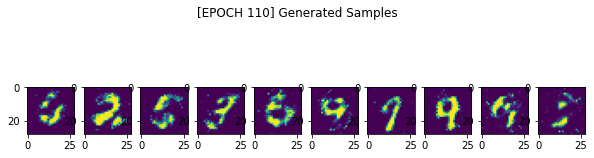

[EPOCH 111] SAMPLED G LOSS : 0.9942994117736816, SAMPLED D LOSS : 0.4932476878166199
[EPOCH 111] SAMPLED G LOSS : 1.28129243850708, SAMPLED D LOSS : 0.4616045355796814
[EPOCH 112] SAMPLED G LOSS : 1.0392006635665894, SAMPLED D LOSS : 0.4778093993663788
[EPOCH 112] SAMPLED G LOSS : 1.52078378200531, SAMPLED D LOSS : 0.4655658006668091
[EPOCH 113] SAMPLED G LOSS : 1.0224159955978394, SAMPLED D LOSS : 0.5096486806869507
[EPOCH 113] SAMPLED G LOSS : 0.8033313155174255, SAMPLED D LOSS : 0.5416585206985474
[EPOCH 114] SAMPLED G LOSS : 1.1937339305877686, SAMPLED D LOSS : 0.48467186093330383
[EPOCH 114] SAMPLED G LOSS : 1.1839842796325684, SAMPLED D LOSS : 0.5380076169967651
[EPOCH 115] SAMPLED G LOSS : 1.2782789468765259, SAMPLED D LOSS : 0.4896085262298584
[EPOCH 115] SAMPLED G LOSS : 1.2766621112823486, SAMPLED D LOSS : 0.520021915435791
[EPOCH 116] SAMPLED G LOSS : 0.7708905339241028, SAMPLED D LOSS : 0.5592877268791199
[EPOCH 116] SAMPLED G LOSS : 1.165127158164978, SAMPLED D LOSS : 0.45

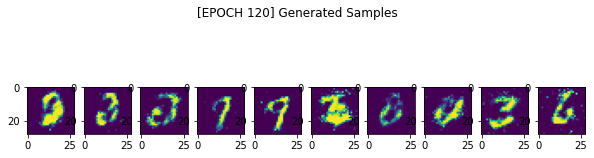

[EPOCH 121] SAMPLED G LOSS : 1.3554773330688477, SAMPLED D LOSS : 0.47985678911209106
[EPOCH 121] SAMPLED G LOSS : 1.3023406267166138, SAMPLED D LOSS : 0.5021860003471375
[EPOCH 122] SAMPLED G LOSS : 1.2526230812072754, SAMPLED D LOSS : 0.5193150043487549
[EPOCH 122] SAMPLED G LOSS : 1.1575924158096313, SAMPLED D LOSS : 0.47693610191345215
[EPOCH 123] SAMPLED G LOSS : 1.3972519636154175, SAMPLED D LOSS : 0.4816119074821472
[EPOCH 123] SAMPLED G LOSS : 1.025856614112854, SAMPLED D LOSS : 0.4549906849861145
[EPOCH 124] SAMPLED G LOSS : 0.9637711048126221, SAMPLED D LOSS : 0.4661158323287964
[EPOCH 124] SAMPLED G LOSS : 1.3946698904037476, SAMPLED D LOSS : 0.44399628043174744
[EPOCH 125] SAMPLED G LOSS : 0.9897322654724121, SAMPLED D LOSS : 0.43529266119003296
[EPOCH 125] SAMPLED G LOSS : 1.4466524124145508, SAMPLED D LOSS : 0.4526435136795044
[EPOCH 126] SAMPLED G LOSS : 1.1662697792053223, SAMPLED D LOSS : 0.4485747516155243
[EPOCH 126] SAMPLED G LOSS : 1.3491013050079346, SAMPLED D LOS

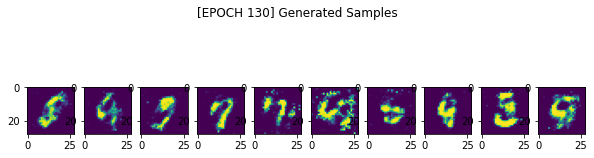

[EPOCH 131] SAMPLED G LOSS : 0.9842479228973389, SAMPLED D LOSS : 0.5456382632255554
[EPOCH 131] SAMPLED G LOSS : 1.3278720378875732, SAMPLED D LOSS : 0.5545945167541504
[EPOCH 132] SAMPLED G LOSS : 1.3953297138214111, SAMPLED D LOSS : 0.568892776966095
[EPOCH 132] SAMPLED G LOSS : 0.9654271006584167, SAMPLED D LOSS : 0.5118800401687622
[EPOCH 133] SAMPLED G LOSS : 0.997533917427063, SAMPLED D LOSS : 0.5035679936408997
[EPOCH 133] SAMPLED G LOSS : 0.6918741464614868, SAMPLED D LOSS : 0.5830242037773132
[EPOCH 134] SAMPLED G LOSS : 1.408078670501709, SAMPLED D LOSS : 0.5327348113059998
[EPOCH 134] SAMPLED G LOSS : 1.1569926738739014, SAMPLED D LOSS : 0.46174582839012146
[EPOCH 135] SAMPLED G LOSS : 1.016498327255249, SAMPLED D LOSS : 0.4583660662174225
[EPOCH 135] SAMPLED G LOSS : 0.8850735425949097, SAMPLED D LOSS : 0.4953474998474121
[EPOCH 136] SAMPLED G LOSS : 0.9902238845825195, SAMPLED D LOSS : 0.48137858510017395
[EPOCH 136] SAMPLED G LOSS : 1.3174951076507568, SAMPLED D LOSS : 0

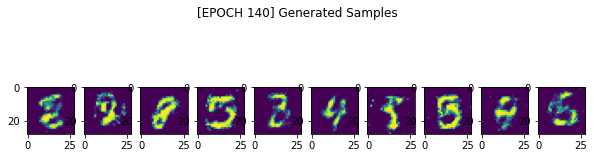

[EPOCH 141] SAMPLED G LOSS : 1.2652063369750977, SAMPLED D LOSS : 0.4641311466693878
[EPOCH 141] SAMPLED G LOSS : 1.0987868309020996, SAMPLED D LOSS : 0.502121090888977
[EPOCH 142] SAMPLED G LOSS : 1.2468547821044922, SAMPLED D LOSS : 0.510944664478302
[EPOCH 142] SAMPLED G LOSS : 1.1873944997787476, SAMPLED D LOSS : 0.5270428657531738
[EPOCH 143] SAMPLED G LOSS : 1.5029776096343994, SAMPLED D LOSS : 0.48826807737350464
[EPOCH 143] SAMPLED G LOSS : 1.3386409282684326, SAMPLED D LOSS : 0.5494064092636108
[EPOCH 144] SAMPLED G LOSS : 0.6567227840423584, SAMPLED D LOSS : 0.5630590915679932
[EPOCH 144] SAMPLED G LOSS : 1.3571945428848267, SAMPLED D LOSS : 0.5303552746772766
[EPOCH 145] SAMPLED G LOSS : 0.8031269311904907, SAMPLED D LOSS : 0.5281437635421753
[EPOCH 145] SAMPLED G LOSS : 1.2235920429229736, SAMPLED D LOSS : 0.5576354265213013
[EPOCH 146] SAMPLED G LOSS : 0.6864995956420898, SAMPLED D LOSS : 0.600906252861023
[EPOCH 146] SAMPLED G LOSS : 0.8440523147583008, SAMPLED D LOSS : 0

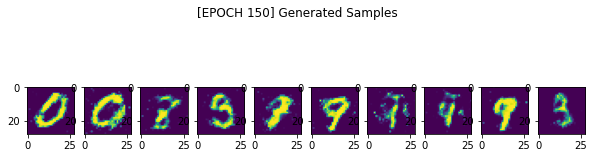

[EPOCH 151] SAMPLED G LOSS : 0.8604129552841187, SAMPLED D LOSS : 0.5640019178390503
[EPOCH 151] SAMPLED G LOSS : 1.1101990938186646, SAMPLED D LOSS : 0.53557288646698
[EPOCH 152] SAMPLED G LOSS : 1.0619993209838867, SAMPLED D LOSS : 0.4477137327194214
[EPOCH 152] SAMPLED G LOSS : 1.3895156383514404, SAMPLED D LOSS : 0.46435463428497314
[EPOCH 153] SAMPLED G LOSS : 1.2483203411102295, SAMPLED D LOSS : 0.49351203441619873
[EPOCH 153] SAMPLED G LOSS : 1.1319537162780762, SAMPLED D LOSS : 0.46240872144699097
[EPOCH 154] SAMPLED G LOSS : 0.9597225189208984, SAMPLED D LOSS : 0.5171406269073486
[EPOCH 154] SAMPLED G LOSS : 1.172629475593567, SAMPLED D LOSS : 0.48779296875
[EPOCH 155] SAMPLED G LOSS : 0.7217930555343628, SAMPLED D LOSS : 0.5657910704612732
[EPOCH 155] SAMPLED G LOSS : 0.7152292728424072, SAMPLED D LOSS : 0.5260383486747742
[EPOCH 156] SAMPLED G LOSS : 1.1698462963104248, SAMPLED D LOSS : 0.48731428384780884
[EPOCH 156] SAMPLED G LOSS : 1.4253344535827637, SAMPLED D LOSS : 0.4

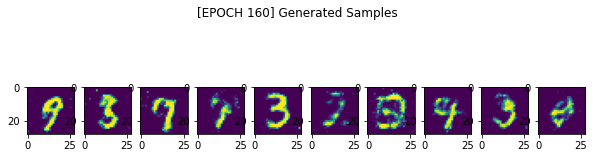

[EPOCH 161] SAMPLED G LOSS : 1.2358322143554688, SAMPLED D LOSS : 0.5324822664260864
[EPOCH 161] SAMPLED G LOSS : 0.6308454871177673, SAMPLED D LOSS : 0.5724860429763794
[EPOCH 162] SAMPLED G LOSS : 1.0886509418487549, SAMPLED D LOSS : 0.5035206079483032
[EPOCH 162] SAMPLED G LOSS : 1.0708773136138916, SAMPLED D LOSS : 0.48577022552490234
[EPOCH 163] SAMPLED G LOSS : 1.411970615386963, SAMPLED D LOSS : 0.5358893275260925
[EPOCH 163] SAMPLED G LOSS : 1.2946908473968506, SAMPLED D LOSS : 0.5596007108688354
[EPOCH 164] SAMPLED G LOSS : 1.4981937408447266, SAMPLED D LOSS : 0.49559637904167175
[EPOCH 164] SAMPLED G LOSS : 0.9982587099075317, SAMPLED D LOSS : 0.523685097694397
[EPOCH 165] SAMPLED G LOSS : 1.1350157260894775, SAMPLED D LOSS : 0.46575024724006653
[EPOCH 165] SAMPLED G LOSS : 1.390363097190857, SAMPLED D LOSS : 0.5215315818786621
[EPOCH 166] SAMPLED G LOSS : 1.1464039087295532, SAMPLED D LOSS : 0.4881018400192261
[EPOCH 166] SAMPLED G LOSS : 1.195066213607788, SAMPLED D LOSS : 

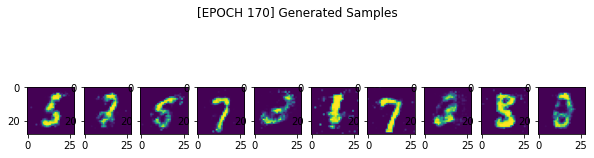

[EPOCH 171] SAMPLED G LOSS : 0.9992281198501587, SAMPLED D LOSS : 0.4951494336128235
[EPOCH 171] SAMPLED G LOSS : 1.7536828517913818, SAMPLED D LOSS : 0.6494982838630676
[EPOCH 172] SAMPLED G LOSS : 1.5011522769927979, SAMPLED D LOSS : 0.5494747757911682
[EPOCH 172] SAMPLED G LOSS : 0.8968697190284729, SAMPLED D LOSS : 0.5579200983047485
[EPOCH 173] SAMPLED G LOSS : 1.5878057479858398, SAMPLED D LOSS : 0.5339130759239197
[EPOCH 173] SAMPLED G LOSS : 0.8753985166549683, SAMPLED D LOSS : 0.5173410773277283
[EPOCH 174] SAMPLED G LOSS : 1.3914525508880615, SAMPLED D LOSS : 0.47826915979385376
[EPOCH 174] SAMPLED G LOSS : 1.5452302694320679, SAMPLED D LOSS : 0.5877536535263062
[EPOCH 175] SAMPLED G LOSS : 1.159354329109192, SAMPLED D LOSS : 0.547982931137085
[EPOCH 175] SAMPLED G LOSS : 1.7398765087127686, SAMPLED D LOSS : 0.5511241555213928
[EPOCH 176] SAMPLED G LOSS : 1.032346248626709, SAMPLED D LOSS : 0.5192142724990845
[EPOCH 176] SAMPLED G LOSS : 1.3481993675231934, SAMPLED D LOSS : 0

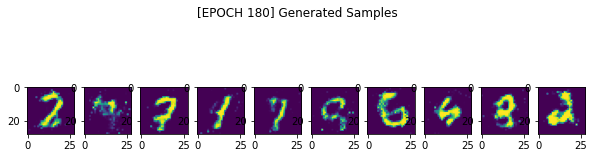

[EPOCH 181] SAMPLED G LOSS : 1.7152278423309326, SAMPLED D LOSS : 0.578565776348114
[EPOCH 181] SAMPLED G LOSS : 1.0294930934906006, SAMPLED D LOSS : 0.526593804359436
[EPOCH 182] SAMPLED G LOSS : 1.1979954242706299, SAMPLED D LOSS : 0.47725310921669006
[EPOCH 182] SAMPLED G LOSS : 1.2000949382781982, SAMPLED D LOSS : 0.5116569399833679
[EPOCH 183] SAMPLED G LOSS : 1.592362880706787, SAMPLED D LOSS : 0.46359872817993164
[EPOCH 183] SAMPLED G LOSS : 0.8311173319816589, SAMPLED D LOSS : 0.58070969581604
[EPOCH 184] SAMPLED G LOSS : 0.7117190957069397, SAMPLED D LOSS : 0.5222856402397156
[EPOCH 184] SAMPLED G LOSS : 1.1364765167236328, SAMPLED D LOSS : 0.47676628828048706
[EPOCH 185] SAMPLED G LOSS : 1.0569016933441162, SAMPLED D LOSS : 0.5047630071640015
[EPOCH 185] SAMPLED G LOSS : 1.2043226957321167, SAMPLED D LOSS : 0.5058200359344482
[EPOCH 186] SAMPLED G LOSS : 0.9464902877807617, SAMPLED D LOSS : 0.5152627825737
[EPOCH 186] SAMPLED G LOSS : 1.292492389678955, SAMPLED D LOSS : 0.481

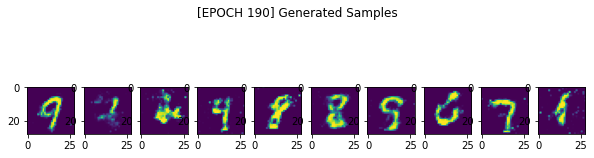

[EPOCH 191] SAMPLED G LOSS : 1.4732816219329834, SAMPLED D LOSS : 0.5602031946182251
[EPOCH 191] SAMPLED G LOSS : 0.7725378274917603, SAMPLED D LOSS : 0.5482996702194214
[EPOCH 192] SAMPLED G LOSS : 1.0439478158950806, SAMPLED D LOSS : 0.47027352452278137
[EPOCH 192] SAMPLED G LOSS : 0.8477658033370972, SAMPLED D LOSS : 0.5358901619911194
[EPOCH 193] SAMPLED G LOSS : 0.8619515895843506, SAMPLED D LOSS : 0.5714651346206665
[EPOCH 193] SAMPLED G LOSS : 1.3278148174285889, SAMPLED D LOSS : 0.5056220293045044
[EPOCH 194] SAMPLED G LOSS : 1.1659454107284546, SAMPLED D LOSS : 0.4853643774986267
[EPOCH 194] SAMPLED G LOSS : 1.1878772974014282, SAMPLED D LOSS : 0.4776829779148102
[EPOCH 195] SAMPLED G LOSS : 1.292395830154419, SAMPLED D LOSS : 0.5497213006019592
[EPOCH 195] SAMPLED G LOSS : 1.175049066543579, SAMPLED D LOSS : 0.5936896800994873
[EPOCH 196] SAMPLED G LOSS : 1.2649598121643066, SAMPLED D LOSS : 0.5177671909332275
[EPOCH 196] SAMPLED G LOSS : 1.2193080186843872, SAMPLED D LOSS : 

In [24]:
max_epoch = 200

for epoch in tqdm(range(max_epoch)):        
    for idx, sample in enumerate(train_dataloader):
        g_loss, d_loss = train(generator, discriminator, gen_optimizer, dis_optimizer, dim_z, sample)
        if idx % 200 == 0:
            print('[EPOCH {}] SAMPLED G LOSS : {}, SAMPLED D LOSS : {}'.format(epoch, g_loss, d_loss))

    if epoch % 10 == 0:
        fig, ax = plt.subplots(1, 10, figsize=(10, 3))
        for i in range(10):
            ax[i].imshow(test(generator, img_size, dim_z))
        plt.suptitle('[EPOCH {}] Generated Samples'.format(epoch))
        plt.pause(0.1)
        

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(10, 3))
for i in range(10):
    ax[i].imshow(test(generator, img_size, dim_z))
